In [1]:
library(fixest)
library(dplyr)
library(readr)
library(tidyr)
library(stats)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [84]:
base_cadastro_stone = read_csv('base_cadastrados_stone.csv')
base_cadastro_ton = read_csv('base_cadastrados_ton.csv')
base_cadastro_ton = read_csv('base_ativos_30d_ton.csv')

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 16078711 Columns: 26
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): document, tpv_stone, share_tpv_debit, share_tpv_chip_present, sha...
dbl  (15): tpv_total, share_tpv_credit, average_ticket_size, month, year, to...
date  (1): reference_month

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [85]:
base$uf = substr(base$municipio,1,2)

In [ ]:
m1 = feols(log_total_tpv_credit ~ log_total_tpv_credit_lag + log_total_tpv_credit_mun + media_cnpjs_por_socio + qtd_socios_no_mes | municipio + grupo_cnae_fiscal_principal + reference_month, base)

In [ ]:
summary(m1)

In [ ]:
base$yhat = predict(m1, newdata = base)         

In [ ]:
base$resid = base$log_total_tpv_credit - base$yhat

In [ ]:
hist(base$resid,breaks=100)

In [ ]:
resid_median = median(base$resid,na.rm=T)

In [ ]:
base = base %>% mutate(resid_above_median = ifelse(resid >= resid_median,1,0))

In [ ]:
base$resid_above_median = base$resid_above_median %>% replace_na(0)

In [ ]:
document_agg = base %>%   
               group_by(document) %>% summarise(qtd_above_median = sum(resid_above_median))

In [ ]:
hist(document_agg$qtd_above_median,breaks=10)

In [ ]:
quantile(document_agg$qtd_above_median)

In [ ]:
document_winners = document_agg %>% filter(qtd_above_median %in% c(11)) %>% pull(document)

In [ ]:
base_winners = base %>% filter(document %in% document_winners)

In [ ]:
base_

In [ ]:
# Filtrando 'para os documentos que constam como ativos

In [19]:
base_ativos = read_csv('document_winners.csv')

Rows: 337784 Columns: 36
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (8): document, tpv_stone, share_tpv_debit, share_tpv_chip_present, sha...
dbl  (27): tpv_total, share_tpv_credit, average_ticket_size, average_spend_p...
date  (1): reference_month

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [22]:
length(unique(base_ativos$document))

[1] 29259

In [93]:
base_ativos = base_ativos %>% pull(DocumentNumber)

In [94]:
base_winners_active = base_winners %>% filter(document %in% base_ativos) 
base_losers_active = base_losers %>% filter(document %in% base_ativos) 

In [ ]:
# % de ativos na base de vencedores
((base_winners_active %>% nrow())/(base_winners %>% nrow()))*100

In [104]:
# % de ativos na base de perdedores
((base_losers_active %>% nrow())/(base_losers %>% nrow()))*100

[1] 71.31909

In [ ]:
write_csv(base_winners_active,'document_winners.csv')
write_csv(base_losers_active,'document_losers.csv')

In [18]:
nrow(base_winners_active)

ERROR: Error in eval(expr, envir, enclos): object 'base_winners_active' not found


In [ ]:
doc_ex = base_winners %>% filter(document == document_winners[10])

In [ ]:
library(ggplot2)

# Supondo que seu dataframe se chama doc_ex
ggplot(doc_ex, aes(x = reference_month)) +
  geom_line(aes(y = log_total_tpv_credit, color = "Realizado"), size = 1) +
  geom_line(aes(y = yhat, color = "Projetado"), linetype = "dashed", size = 1) +
  scale_color_manual(
    values = c("Realizado" = "blue", "Projetado" = "red"),
    name = "Legenda"
  ) +
  labs(
    x = "Mês de Referência",
    y = "Log do Faturamento",
    title = "Comparativo entre Valor Realizado e Projetado"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5),
    legend.position = "bottom"
  )


In [ ]:
# Diagnóstico de resíduos positivos sendo mais possíveis em empresas maiores 
## Solução proposta: adicionar o decil do faturamento da firma, considerando a média do log do faturamento no período disponível

In [ ]:
ggplot() +
  geom_histogram(aes(x = base$log_total_tpv_credit, y = ..density..),
                 bins = 100, fill = "red", alpha = 0.5) +
  geom_histogram(aes(x = base_winners$log_total_tpv_credit, y = ..density..),
                 bins = 100, fill = "blue", alpha = 0.5) +
  labs(title = "Distribuição do log_total_tpv_credit",
       x = "log_total_tpv_credit", y = "Densidade") +
  theme_minimal()


In [ ]:
base_agg = base %>%
  group_by(document) %>%
  summarise(media_faturamento = mean(log_total_tpv_credit, na.rm = TRUE)) %>%
  mutate(decil_media_faturamento = ntile(media_faturamento, 10))

In [ ]:
base = base %>% left_join(.,base_agg,by=("document"))

In [ ]:
m2 = feols(log_total_tpv_credit ~ log_total_tpv_credit_lag + log_total_tpv_credit_mun + media_cnpjs_por_socio + qtd_socios_no_mes | municipio + grupo_cnae_fiscal_principal + reference_month + decil_media_faturamento, base)

In [ ]:
summary(m2)

In [ ]:
base$yhat = predict(m2, newdata = base)         

In [ ]:
base$resid = base$log_total_tpv_credit - base$yhat

In [ ]:
resid_median = median(base$resid,na.rm=T)

In [ ]:
base = base %>% mutate(resid_above_median = ifelse(resid >= resid_median,1,0))

In [ ]:
base$resid_above_median = base$resid_above_median %>% replace_na(0)

In [ ]:
document_agg = base %>%   
               group_by(document) %>% summarise(qtd_above_median = sum(resid_above_median))

In [ ]:
hist(document_agg$qtd_above_median,breaks=11)

In [ ]:
document_winners = document_agg %>% filter(qtd_above_median %in% c(11)) %>% pull(document)

In [ ]:
base_winners = base %>% filter(document %in% document_winners)

In [ ]:
ggplot() +
  geom_histogram(aes(x = base$log_total_tpv_credit, y = ..density..),
                 bins = 100, fill = "red", alpha = 0.5) +
  geom_histogram(aes(x = base_winners$log_total_tpv_credit, y = ..density..),
                 bins = 100, fill = "blue", alpha = 0.5) +
  labs(title = "Distribuição do log_total_tpv_credit",
       x = "log_total_tpv_credit", y = "Densidade") +
  theme_minimal()


In [86]:
base_agg = base %>%
  group_by(document) %>%
  summarise(media_faturamento = mean(log_total_tpv_credit, na.rm = TRUE)) %>%
  mutate(decil_media_faturamento = ntile(media_faturamento, 10))

In [87]:
base = base %>% left_join(.,base_agg,by=("document"))

In [88]:
m2 = feols(log_total_tpv_credit ~ log_total_tpv_credit_lag:factor(decil_media_faturamento) + log_total_tpv_credit_mun:factor(decil_media_faturamento) + media_cnpjs_por_socio:factor(decil_media_faturamento) + qtd_socios_no_mes:factor(decil_media_faturamento) | municipio + grupo_cnae_fiscal_principal + reference_month + decil_media_faturamento, base, cluster = ~ municipio)

NOTES: 3,992,625 observations removed because of NA and infinite values (LHS: 1,749,506, RHS: 3,329,802, Fixed-effects: 217,430).
       3/0/0/0 fixed-effect singletons were removed (3 observations).



In [89]:
base$yhat = predict(m2, newdata = base)         

In [90]:
base$resid = base$log_total_tpv_credit - base$yhat

In [91]:
base_resid_decil = base %>% group_by(decil_media_faturamento) %>% summarise(mean_resid = mean(resid,na.rm=T),
                                                                           sd_resid = sd(resid,na.rm=T))

In [92]:
base_ = base %>% left_join(.,base_resid_decil,by=c("decil_media_faturamento")) %>% mutate(resid_std = 2*((resid - mean_resid)/sd_resid)) %>% mutate(resid_above_2_std = ifelse(resid_std >= 1.28,1,0),
                                                                                                                                                   resid_below_2_std = ifelse(resid_std <= -1.28,1,0))

In [93]:
base_$resid_above_2_std = base_$resid_above_2_std %>% replace_na(0)
base_$resid_below_2_std = base_$resid_below_2_std %>% replace_na(0)

In [94]:
base_resid_decil = base_ %>% group_by(document,decil_media_faturamento) %>% summarise(total_resid_above_2_std = sum(resid_above_2_std),
                                                                                     total_resid_below_2_std = sum(resid_below_2_std))

`summarise()` has grouped output by 'document'. You can override using the
`.groups` argument.


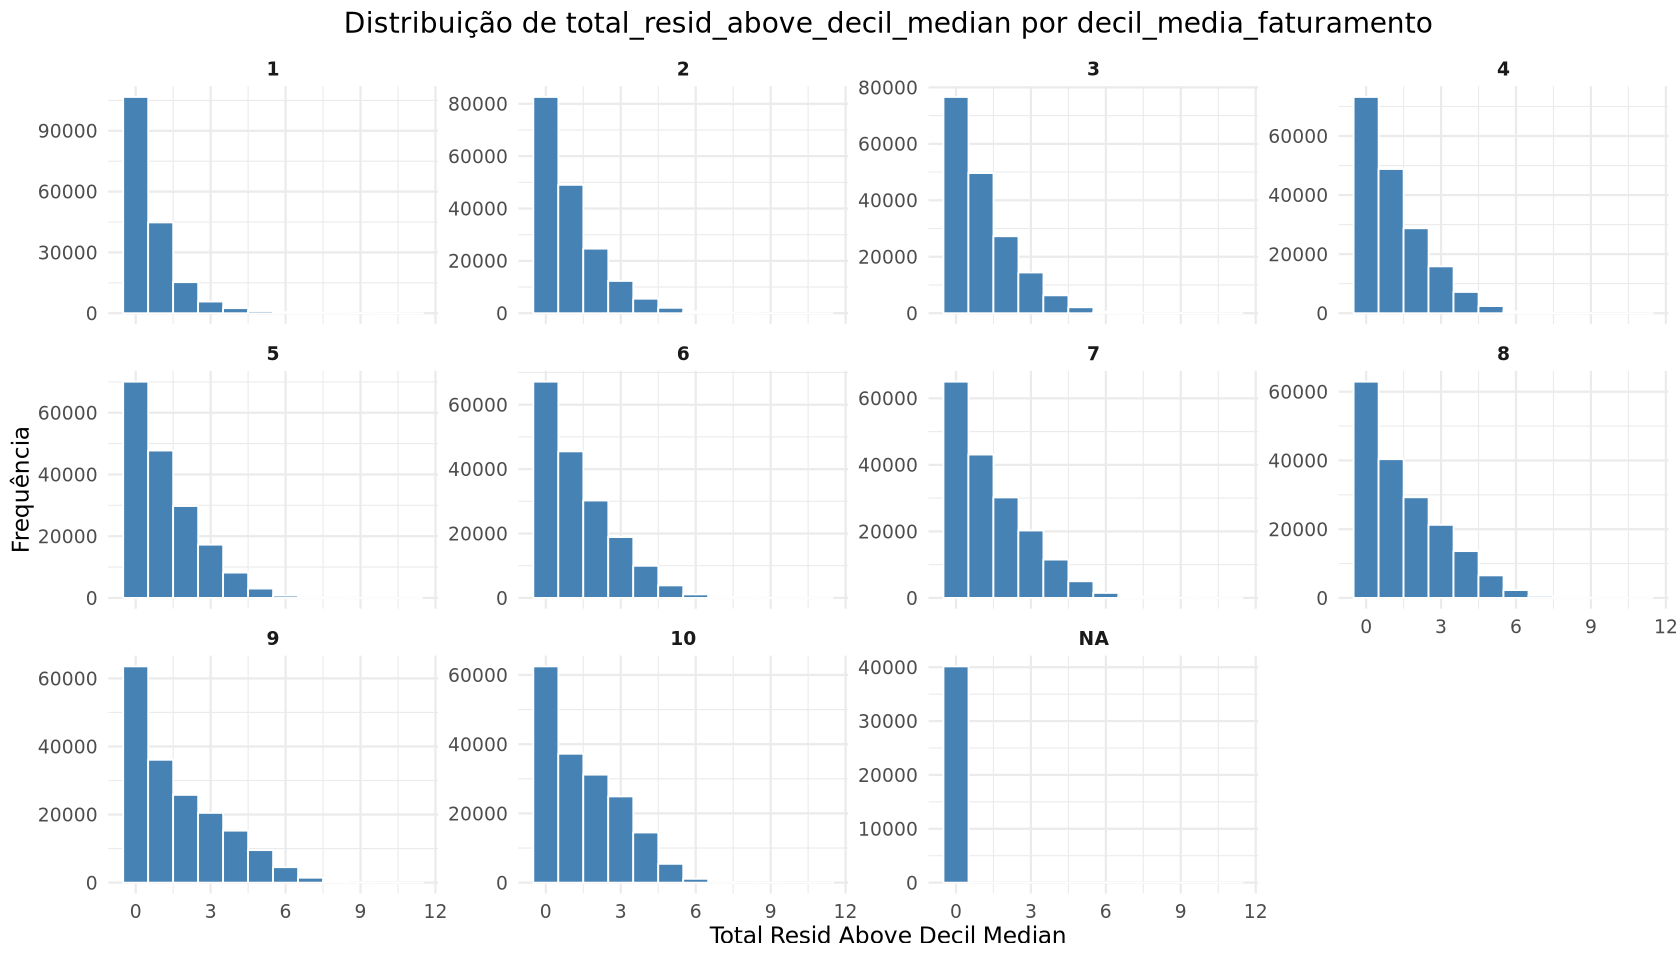

In [13]:
options(repr.plot.width = 14, repr.plot.height = 8)

base_resid_decil %>%
  ggplot(aes(x = total_resid_above_2_std)) +
  geom_histogram(bins = 12, fill = "steelblue", color = "white") +
  facet_wrap(~ decil_media_faturamento, scales = "free_y") +
  labs(
    title = "Distribuição de total_resid_above_decil_median por decil_media_faturamento",
    x = "Total Resid Above Decil Median",
    y = "Frequência"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5),
    strip.text = element_text(face = "bold")
  )

In [95]:
document_winners = base_resid_decil %>% filter(total_resid_above_2_std %in% c(6,7,8,9,10,11)) %>% pull(document)
document_losers = base_resid_decil %>% filter(total_resid_below_2_std %in% c(6,7,8,9,10,11)) %>% pull(document)

In [96]:
length(document_winners)

[1] 42821

In [97]:
length(document_losers)

[1] 17688

In [98]:
base_winners = base_ %>% filter(document %in% document_winners)
base_losers = base_ %>% filter(document %in% document_losers)

Warning message:
“Removed 1749506 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 3148 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 699 rows containing non-finite values (`stat_bin()`).”


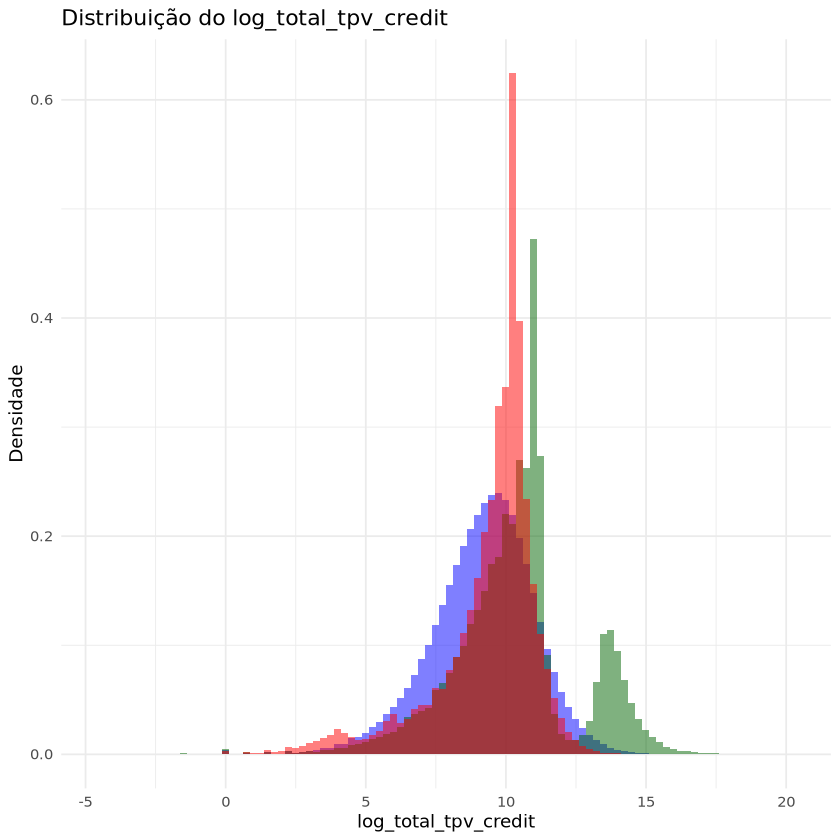

In [99]:
ggplot() +
  geom_histogram(aes(x = base_$log_total_tpv_credit, y = ..density..),
                 bins = 100, fill = "blue", alpha = 0.5) +
  geom_histogram(aes(x = base_winners$log_total_tpv_credit, y = ..density..),
                 bins = 100, fill = "darkgreen", alpha = 0.5) +
  geom_histogram(aes(x = base_losers$log_total_tpv_credit, y = ..density..),
                 bins = 100, fill = "red", alpha = 0.5) +
  labs(title = "Distribuição do log_total_tpv_credit",
       x = "log_total_tpv_credit", y = "Densidade") +
  theme_minimal()


In [2]:
base_estrutural = read_csv('base_tpv_master_q.csv')

Rows: 11384880 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): document
dbl  (6): q, total_tpv_credit, municipio, total_tpv_credit_mun, cnae_fiscal_...
date (1): reference_month

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
base_estrutural$uf = substr(base_estrutural$municipio,1,2)

In [4]:
base_estrutural = base_estrutural %>% mutate(log_q = log(q))

In [5]:
m3 = feols(log_q ~ 1 | document + reference_month^municipio + reference_month^grupo_cnae_fiscal_principal + uf^grupo_cnae_fiscal_principal, base_estrutural, cluster = ~ document,fixef.keep_names=T)

NOTES: 1,058,786 observations removed because of NA and infinite values (LHS: 1,058,631, Fixed-effects: 164).
       37,913/1,929/18/23 fixed-effect singletons were removed (39,836 observations).



In [6]:
summary(m3)

OLS estimation, Dep. Var.: log_q
Observations: 10,286,258
Fixed-effects: document: 1,045,327,  reference_month^municipio: 63,601,
 reference_month^grupo_cnae_fiscal_principal: 923,
 uf^grupo_cnae_fiscal_principal: 1,768
RMSE: 0.510052   Adj. R2: 0.897867

In [7]:
base_estrutural$yhat = predict(m3, newdata = base_estrutural)         

In [8]:
base_estrutural$resid = base_estrutural$log_q - base_estrutural$yhat

In [9]:
fe_list <- fixef(m3)            # lista de vetores por FE
fe_doc  <- fe_list$document     # named vector: nomes = níveis de document

df_doc_fe <- data.frame(
  document   = names(fe_doc),
  fe_document = as.numeric(fe_doc),
  row.names = NULL)


NOTE: The fixed-effects are not regular, they cannot be straightforwardly interpreted. The number of references is only approximate.



In [10]:
base_estrutural_res = base_estrutural %>% left_join(.,df_doc_fe,by=c('document'))

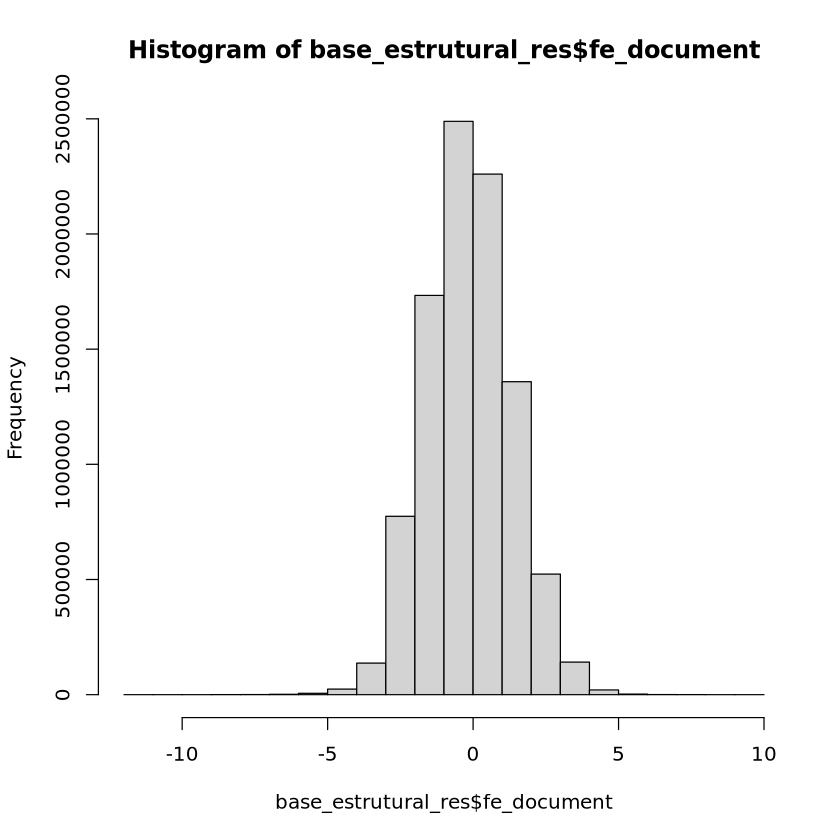

In [11]:
hist(base_estrutural_res$fe_document)

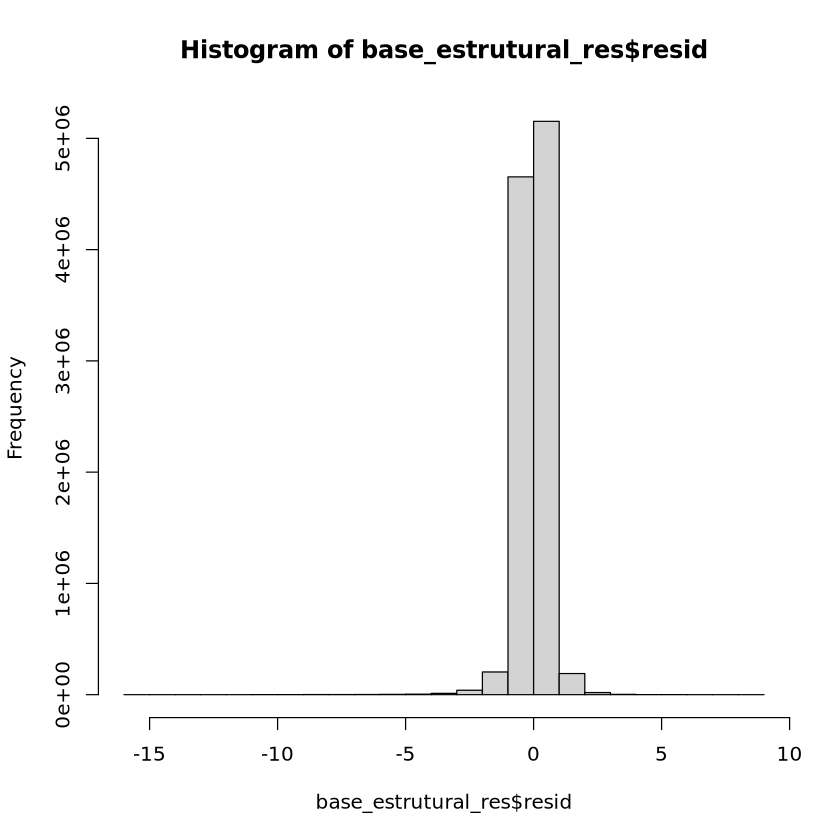

In [12]:
hist(base_estrutural_res$resid)

In [13]:
base_estrutural_res = base_estrutural_res %>%
  arrange(document, reference_month) %>%
  group_by(document) %>%
  mutate(resid_3m = zoo::rollapply(resid, width = 3, FUN = mean, align = "right", fill = NA, partial = TRUE))


In [14]:
base_estrutural_res_filtered = base_estrutural_res %>% filter(!is.na(fe_document))

In [15]:
base_estrutural_res_filtered_0725 = base_estrutural_res_filtered %>% filter(reference_month == "2025-07-01")

In [16]:
# supondo que as colunas existam
summary_stats <- base_estrutural_res_filtered_0725 %>%
  summarise(
    mean_fe = mean(fe_document, na.rm = TRUE),
    mean_resid3m = mean(resid_3m, na.rm = TRUE)
  )


Warning message:
“Removed 73358 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 73358 rows containing missing values (`geom_hline()`).”
Warning message:
“Removed 73358 rows containing missing values (`geom_text()`).”


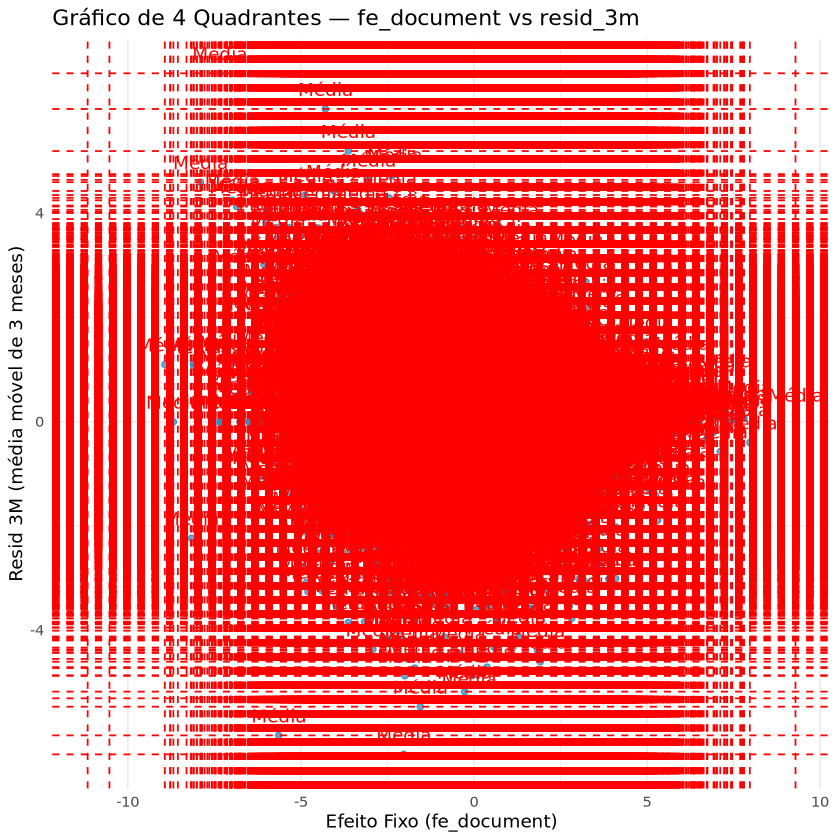

In [81]:
ggplot(base_estrutural_res_filtered_0725, aes(x = fe_document, y = resid_3m)) +
  geom_point(alpha = 0.7, color = "#2c7fb8") +
  geom_vline(xintercept = summary_stats$mean_fe, linetype = "dashed", color = "red") +
  geom_hline(yintercept = summary_stats$mean_resid3m, linetype = "dashed", color = "red") +
  geom_text(
    data = summary_stats,
    aes(x = mean_fe, y = mean_resid3m),
    label = "Média", color = "red", vjust = -1
  ) +
  labs(
    title = "Gráfico de 4 Quadrantes — fe_document vs resid_3m",
    x = "Efeito Fixo (fe_document)",
    y = "Resid 3M (média móvel de 3 meses)"
  ) +
  theme_minimal()


In [17]:
base_winners = base_estrutural_res_filtered_0725 %>% filter(fe_document >= 0, resid_3m >= 0)